In [27]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
sns.set(font_scale=1.2)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

In [28]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 1.0.2.


In [47]:
df = pd.read_csv("df_shape_coronal.csv")
df = df.dropna(how="any")
print(df.columns)
genotype_counts = df['genotype'].value_counts()
print(genotype_counts)
print(df.head())
print(df.info())
print(df.describe())

Index(['Unnamed: 0', 'eccentricity', 'major_axis_length', 'minor_axis_length',
       'perimeter', 'area', 'Lambda2', 'curv2D', 'genotype', 'embryoID',
       'shape parameter'],
      dtype='object')
itga5--                      21354
fbn2b--                      12895
fn1a--fn1b--cdh2--           12327
wt                           11826
itga5--cdh2--                11281
fbn2b--_fn1a--_fn1b--        10805
cdh2                         10242
fn1a--fn1b--                  9145
cdh2--fbn2b--                 8781
cdh2MOfbn2b--fn1a--fn1b--     6528
Name: genotype, dtype: int64
   Unnamed: 0  eccentricity  major_axis_length  minor_axis_length   perimeter  \
0           0      0.662892          40.713568          30.482847  134.876154   
1           0      0.951724          57.581676          17.674993  134.769553   
2           0      0.740555          42.928068          28.847469  119.982756   
3           0      0.918562          57.419112          22.696386  138.455844   
4           0  

In [48]:
#let's focus on wt, cdh2, and itga5--cdh2--
genotypes = ["wt", "cdh2", "itga5--cdh2--"]
df = df[df["genotype"].isin(genotypes)]
genotype_counts = df['genotype'].value_counts()
print(genotype_counts)

wt               11826
itga5--cdh2--    11281
cdh2             10242
Name: genotype, dtype: int64


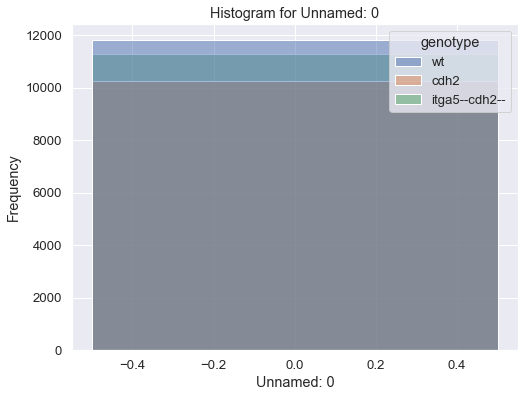

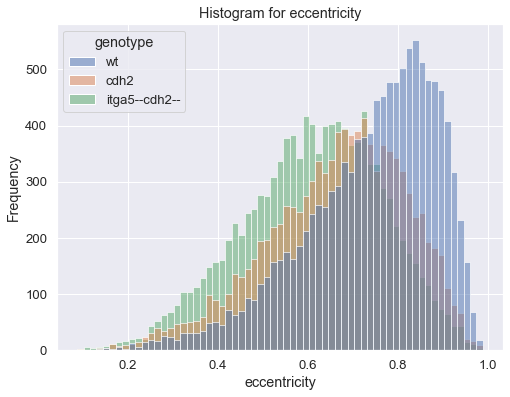

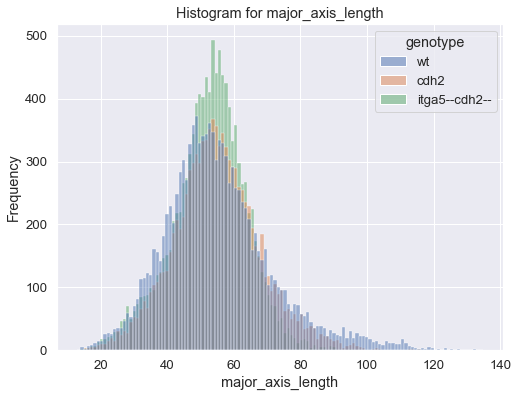

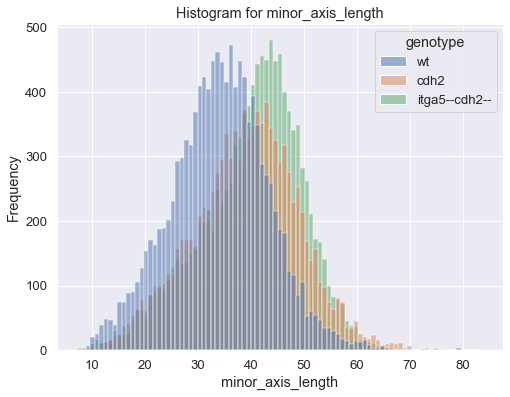

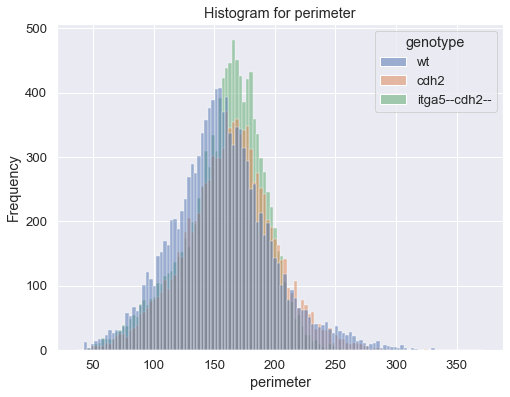

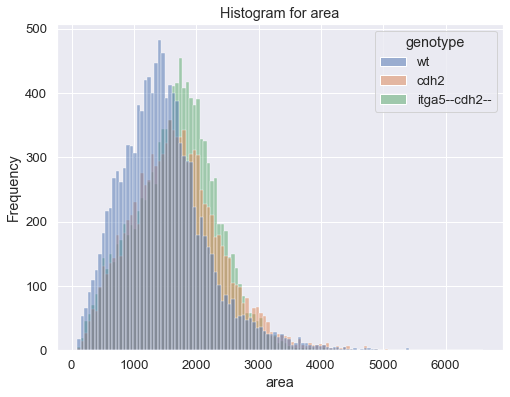

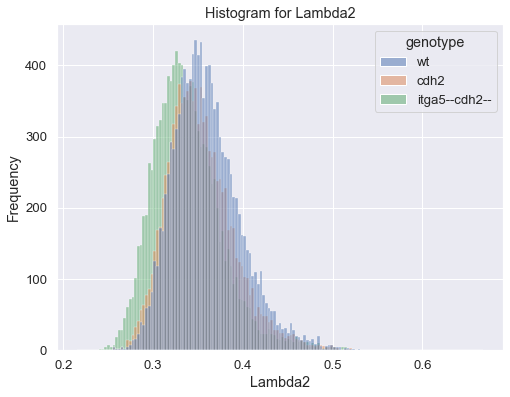

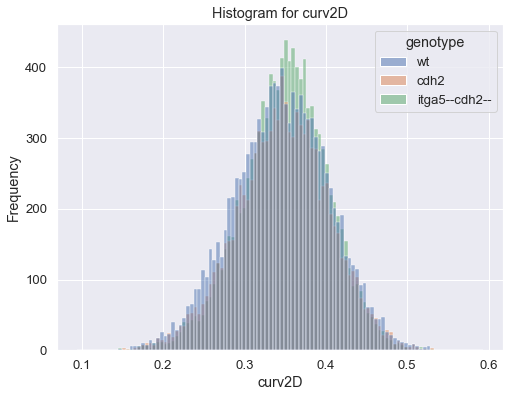

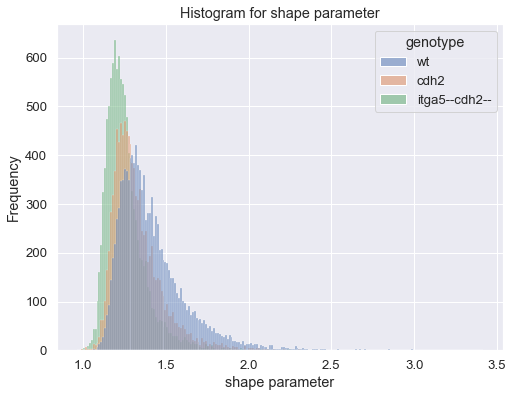

In [49]:
# EDA - let's look at distributions, outliers, and correlations in the features

# Looking or univariate information:
#  For numerical data, plot histograms
for column in df: 
    if np.issubdtype(df[column], np.number): 
        plt.figure(figsize=(8, 6))
        sns.histplot(df, x=column, hue='genotype')
        plt.title(f'Histogram for {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()
    

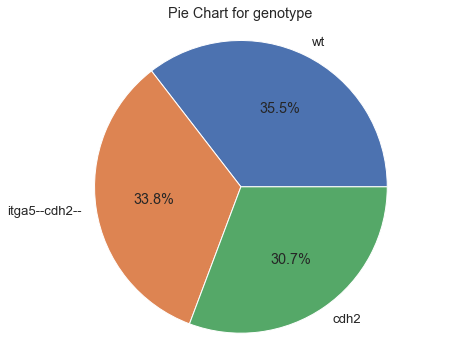

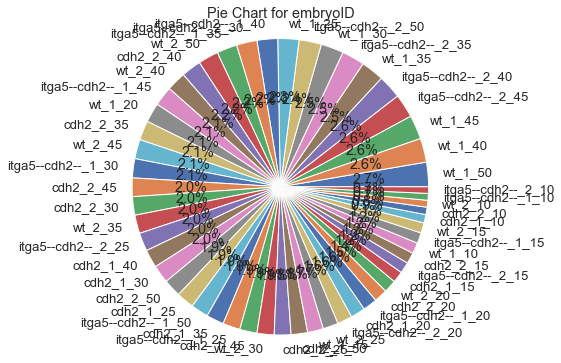

In [50]:
#. For categorical data, make a pie chart
categorical_columns = df.select_dtypes(include=['object', 'category'])
for column in categorical_columns.columns:
    category_counts = categorical_columns[column].value_counts()
    plt.figure(figsize=(8, 6))
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
    plt.title(f'Pie Chart for {column}')
    plt.axis('equal')
    plt.savefig('pieChart'+column+'.jpg')
    plt.show()

In [51]:
# discard low quality data
df = df[(df["area"] > 500) & (df["area"] < 3000)] 
df = df.drop(columns="Unnamed: 0")
genotype_counts = df['genotype'].value_counts()
print(genotype_counts)

wt               10759
itga5--cdh2--    10604
cdh2              9430
Name: genotype, dtype: int64


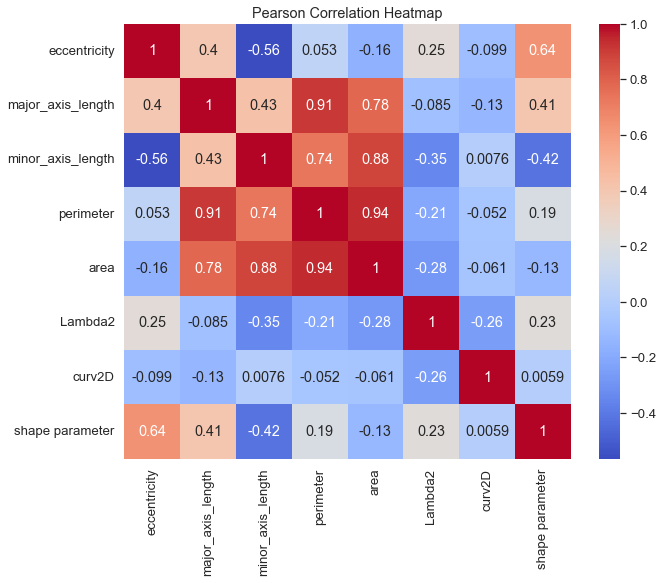

In [52]:
# Calculate and display Pearson correlation coefficients
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Pearson Correlation Heatmap")
plt.show()

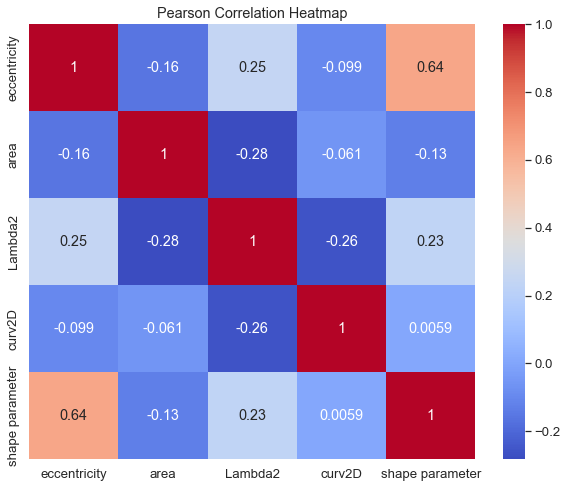

In [54]:
# Feature selection - area and perimeter track very closely, and major_axis and perimeter track very closely. 
# dropping perimeter.
df = df.drop(columns=["perimeter", "minor_axis_length", "major_axis_length"])
# Calculate and display Pearson correlation coefficients
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Pearson Correlation Heatmap")
plt.show()

In [55]:
X, y = df.drop(["genotype", "embryoID"], axis=1), df.genotype
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on your class labels and transform them to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

class_mapping = dict(zip(label_encoder.transform(label_encoder.classes_),label_encoder.classes_))

#weight infrequent classes more heavily
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y), y = y)
class_weights = dict(zip(np.unique(y), class_weights))


In [56]:
def showAccuracyMetrics(y_test, y_pred, y_prob, classes_of_interest):
    #y_test is the target label
    #y_pred is the predicted target label
    #y_prob is the predicted probability, which is transformed into y_pred given a threshold value
    #classes_of_interest is a list of the target classes, used to specify the one vs rest scheme 
    
    # show accuracy table
    report = classification_report(y_test, y_pred)
    print(report)

    # binarize labels to index them for ROC
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_test.shape  # (n_samples, n_classes)


    for class_of_interest in classes_of_interest:
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        # the RocCurveDisplay takes y_prob, which are the predicted probabilities of the classes
        #. and the true y_values. It then varies the threshold from 0 to 1, 
        #. for which a value is predicted positive if above the threshold.
        #. Then, we keep track of whether the value is a true positive or a false positive, and 
        #.  plot the true positive rate and false positive rate parameterized by the threshold.
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_prob[:, class_id],
            name=f"{class_of_interest} vs rest",
            color="darkorange",
        )
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"One-vs-Rest ROC curves:\n{class_of_interest} vs rest")
        plt.legend()
        plt.show()

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

# Logistic Regression
#penalty='l2', C=1.0, class_weight={}
logreg = LogisticRegression(class_weight=class_weights)

# since we are using a regularization penalty, we need to standardize. 
# standardize below!   

parameters = {
    'penalty':('l2', 'none'),
    'C':(0.01, 0.1, 1, 10)
}

X_train_std = (X_train - X_train.mean())/X_train.std()
X_test_std = (X_test - X_test.mean())/X_test.std()

clf = GridSearchCV(logreg, parameters)
clf.fit(X_train_std, y_train)
y_pred = clf.predict(X_test_std)

# Calculate ROC-AUC score and plot ROC curve
y_prob = clf.predict_proba(X_test_std)


/Users/AndrewTon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/Users/AndrewTon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/Users/AndrewTon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/Users/AndrewTon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/Users/AndrewTon/anaconda3/lib/p

LogisticRegression(C=0.01,
                   class_weight={'cdh2': 1.0884764934605868,
                                 'itga5--cdh2--': 0.9679680623664026,
                                 'wt': 0.9540229885057471},
                   penalty='none')
               precision    recall  f1-score   support

         cdh2       0.41      0.27      0.33      1940
itga5--cdh2--       0.53      0.65      0.58      2101
           wt       0.54      0.58      0.56      2118

     accuracy                           0.51      6159
    macro avg       0.49      0.50      0.49      6159
 weighted avg       0.50      0.51      0.49      6159



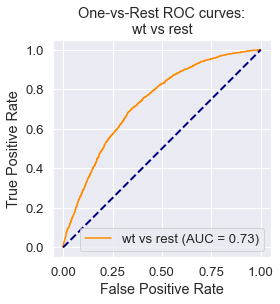

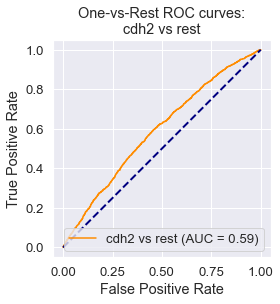

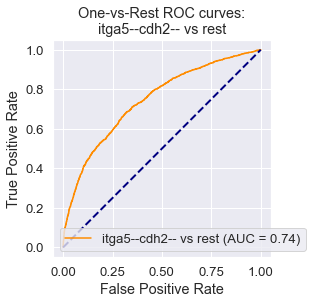

In [58]:
print(clf.best_estimator_)

classes_of_interest = ["wt", "cdh2", "itga5--cdh2--"]

showAccuracyMetrics(y_test, y_pred, y_prob, classes_of_interest)

In [59]:
# show coefficients of the best logistic regression from grid search
lr_coeffs = clf.best_estimator_.coef_
exp_coeffs = np.exp(lr_coeffs)
print(np.shape(lr_coeffs))
print(X_train.columns)
#print(lr_coeffs)
print(exp_coeffs)
# to interpret the exponentiated coefficients, one unit increase in the
#. predictor corresponds to multiplying the odds by the exponential of the coefficient

# Since we've trained our model on standardized data, a unit increase corresponds to one standard deviation increase.
#  We can see clearly that eccentricity and curv2D have low explanatory power. 
#.  Major_axis_length, area, lambda2 and shape parameter have much more explanatory power.


(3, 5)
Index(['eccentricity', 'area', 'Lambda2', 'curv2D', 'shape parameter'], dtype='object')
[[0.9051208  1.11976924 1.1497479  0.99899976 1.13597542]
 [0.91527717 1.07426905 0.78037038 1.02047096 0.57572122]
 [1.20709325 0.83130119 1.11454241 0.98092085 1.52903994]]


         class       Categories  $e^{\beta} - 1$
0           wt     eccentricity        -0.094879
1         cdh2     eccentricity        -0.084723
2   cdh2/itga5     eccentricity         0.207093
3           wt             area         0.119769
4         cdh2             area         0.074269
5   cdh2/itga5             area        -0.168699
6           wt          Lambda2         0.149748
7         cdh2          Lambda2        -0.219630
8   cdh2/itga5          Lambda2         0.114542
9           wt           curv2D        -0.001000
10        cdh2           curv2D         0.020471
11  cdh2/itga5           curv2D        -0.019079
12          wt  shape parameter         0.135975
13        cdh2  shape parameter        -0.424279
14  cdh2/itga5  shape parameter         0.529040


<AxesSubplot:xlabel='Categories', ylabel='$e^{\\beta} - 1$'>

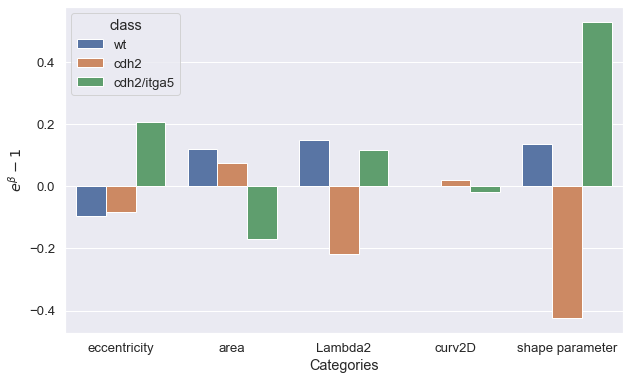

In [60]:
# To visualize this, plot e^beta_i - 1 vs predictor label, for each hue.
plt.figure(figsize=(10, 6))
coeff_df = pd.DataFrame(exp_coeffs-1, columns=X_train.columns)
coeff_df["class"] = coeff_df.index
coeff_df["class"] = coeff_df["class"].replace({0: 'wt', 1: 'cdh2', 2:'cdh2/itga5'})
melted_coeff = pd.melt(coeff_df, id_vars='class', var_name='Categories', value_name=r'$e^{\beta} - 1$')
print(melted_coeff)
sns.barplot(data=melted_coeff, x='Categories', y=r'$e^{\beta} - 1$', hue='class', ci=None)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, ...)
               precision    recall  f1-score   support

         cdh2       0.39      0.29      0.33      1940
itga5--cdh2--       0.58      0.55      0.57      2101
           wt       0.52      0.66      0.58      2118

     accuracy                           0.51      6159
    macro a

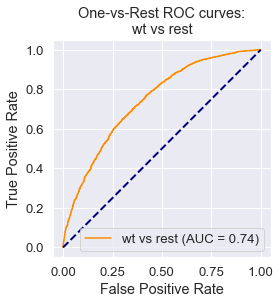

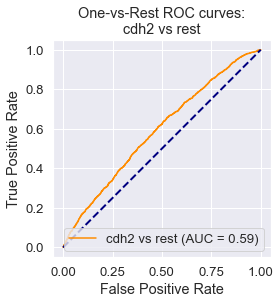

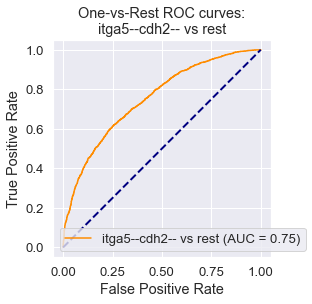

In [61]:
# Create and configure the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # for multiclass classification
    num_class=3,  # Number of classes 
    random_state=0,  # Set a random seed for reproducibility
)

parameters = {
    'n_estimators':(10,25,100)
}

# balance weights in the loss function to penalize missing on the smaller classes
w = [class_weights[key] for key in y_train]

clf = GridSearchCV(xgb_model, parameters)

# Fit the model to the training data
clf.fit(X_train, y_train_encoded, sample_weight=w)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

y_pred_decoded = [class_mapping[pred] for pred in y_pred]

print(clf.best_estimator_)

showAccuracyMetrics(y_test, y_pred_decoded, y_prob, classes_of_interest)

RandomForestClassifier(class_weight={'cdh2': 1.0884764934605868,
                                     'itga5--cdh2--': 0.9679680623664026,
                                     'wt': 0.9540229885057471},
                       max_depth=5)
               precision    recall  f1-score   support

         cdh2       0.38      0.28      0.33      1940
itga5--cdh2--       0.57      0.57      0.57      2101
           wt       0.53      0.65      0.58      2118

     accuracy                           0.51      6159
    macro avg       0.49      0.50      0.49      6159
 weighted avg       0.49      0.51      0.50      6159



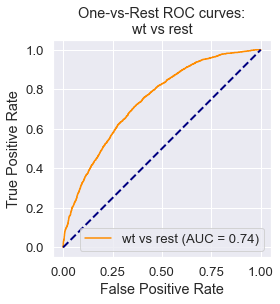

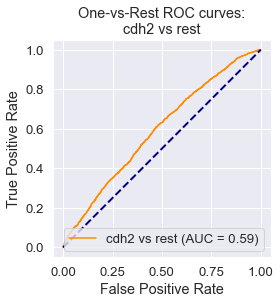

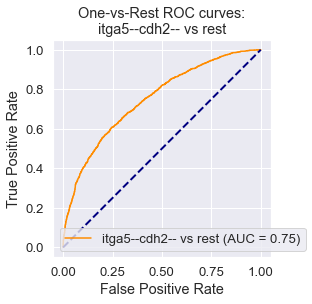

In [62]:
rfc = RandomForestClassifier(class_weight=class_weights)
parameters = {
    'n_estimators':(10, 50, 100),
    'max_depth':(5, 10),
}
clf = GridSearchCV(rfc, parameters)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Calculate ROC-AUC score and plot ROC curve
y_prob = clf.predict_proba(X_test)

classes_of_interest = ["wt", "cdh2", "itga5--cdh2--"]

print(clf.best_estimator_)

showAccuracyMetrics(y_test, y_pred, y_prob, classes_of_interest)

In [63]:
rfc_best = clf.best_estimator_ 
# get feature importances based on mean decrease in impurity,
#. i.e. how much better did the decision tree split the data after encountering each feature? 
feature_importances = rfc_best.feature_importances_
feature_importances_df = pd.DataFrame({'feature': X_train.columns, 'feature_importance': feature_importances})
print(feature_importances_df)

           feature  feature_importance
0     eccentricity            0.251469
1             area            0.100503
2          Lambda2            0.179976
3           curv2D            0.015575
4  shape parameter            0.452476


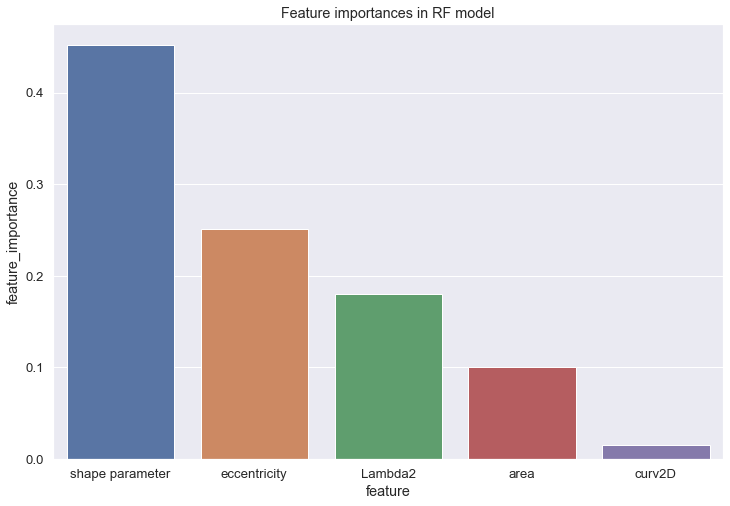

In [64]:
def plot_feature_importances(df):
    df = df.sort_values('feature_importance', ascending=False).reset_index()
    df['normalized_feature_importance'] = df["feature_importance"] / df['feature_importance'].sum()
    plt.figure(figsize = (12,8))
    ax = plt.subplot()
    plt.title('Feature importances in RF model')
    sns.barplot(data=df, x="feature", y="feature_importance")

plot_feature_importances(feature_importances_df)

               precision    recall  f1-score   support

         cdh2       1.00      0.08      0.15       100
itga5--cdh2--       0.82      1.00      0.90       100
           wt       0.59      1.00      0.74       100

     accuracy                           0.69       300
    macro avg       0.80      0.69      0.60       300
 weighted avg       0.80      0.69      0.60       300



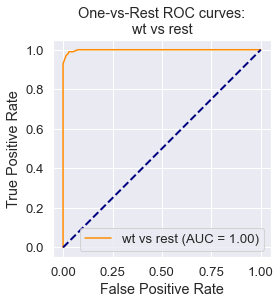

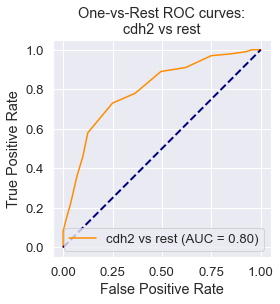

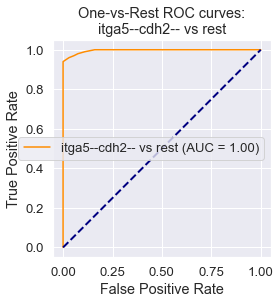

In [70]:
# batch prediction: 
#y_test is the target label
#y_pred is the predicted target label
#y_prob is the predicted probability, which is transformed into y_pred given a threshold value
#classes_of_interest is a list of the target classes, used to specify the one vs rest scheme 

# take 50 samples, call clf.predict on each sample.
#. y_prob = [%class 1 %class2 %class3]
numSamples = 100
sampleBatchSize = 50

y_test_overall = []
y_pred_overall = []
y_prob_overall = []

for genotypeClass in classes_of_interest:
    
    X_genotype = X_test[y_test == genotypeClass]
    
    for sample in range(numSamples):
        randNums = np.random.randint(low=0, high=np.shape(X_genotype)[0],size=sampleBatchSize)
        xBatch = X_genotype.iloc[randNums]
        yBatch = y.iloc[randNums]
        yBatchPred = clf.predict(xBatch)

        # Calculate the proportion of each element
        element_counts = Counter(yBatchPred)
        element_proportions = {key: count / len(yBatchPred) for key, count in element_counts.items()}

        # the order of yBatchProb is determined alphabetically, so hardcoding this for now.
        p0 = element_proportions.get(classes_of_interest[1], 0)
        p1 = element_proportions.get(classes_of_interest[2], 0)
        p2 = element_proportions.get(classes_of_interest[0], 0)
        yBatchProb = [p0, p1, p2]

        y_test_overall.append(genotypeClass)
        y_pred_overall.append(element_counts.most_common(1)[0][0])
        y_prob_overall.append(yBatchProb)
        
    
y_test_overall = np.array(y_test_overall)
y_pred_overall = np.array(y_pred_overall)
y_prob_overall = np.array(y_prob_overall)

showAccuracyMetrics(y_test_overall, y_pred_overall, y_prob_overall, classes_of_interest)


In [26]:
import scipy

def distributionParameters(arr):
    mean = np.mean(arr)
    std = np.var(arr)
    skewness = scipy.stats.skew(arr)
    kurt = scipy.stats.kurtosis(arr)
    entropy = scipy.stats.entropy(arr)
    return mean, std, skewness, kurt, entropy

In [72]:
# batch training: 
numSamples = 1000
sampleBatchSize = 50

# from the training set, roll the individual observations up into groups of 50
# ,and then calculate mean, stdev, kurtosis, chi-sq
# Wrap this up into a dataframe and then train on the dataframe
# Format will look like: 
# columns: mean, median, stdev, kurtosis, 

df_distribution_parameters = pd.DataFrame()

for genotypeClass in classes_of_interest:
    
    X_genotype = X_train[y_train == genotypeClass]
    
    for sample in range(numSamples):
        randNums = np.random.randint(low=0, high=np.shape(X_genotype)[0],size=sampleBatchSize)
        xBatch = X_genotype.iloc[randNums]
        
        dfBatch = pd.DataFrame([])
        
        numeric_columns = xBatch.select_dtypes(include=['float64', 'int64']).columns
        for column in numeric_columns:
            arr = xBatch[column].values
            mean,std,skew,kurt,entropy = distributionParameters(arr)
            dfBatch[column+" mean"] = mean
            
        
        dfBatch["genotype"] = genotypeClass
        df_distribution_parameters = pd.concat(df_distribution_parameters, dfBatch)
        


/Users/AndrewTon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"